<a href="https://colab.research.google.com/github/iamsusiep/slp2019/blob/master/ML_notebook_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook compiles the acoustic, prosodic, and lexical features we have collected, then trains a Random Forest model to predict a film's average IMDB rating from them. 

After that, the notebook delves into exploratory data analysis and an exploration of feature importances. 

Extra code used for feature generation is included at the bottom of the notebook as well. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
!pip install shap

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 266kB 4.8MB/s 
  Created wheel for shap: filename=shap-0.33.0-cp36-cp36m-linux_x86_64.whl size=382258 sha256=8fc008adccab31289e88245e397274aa2b312877d7c4af40fab473c96d32f99b
  Stored in directory: /root/.cache/pip/wheels/39/0f/88/a8124d43431284e10f263ffe449e119344c6145c3a165d186c
Successfully built shap


In [0]:
# load in CSVs
# first is youtube trailer links; second is IMDB ids for those movies
# third is their average ratings and num votes
# fourth is basic film metadata
youtubeIDs = pd.read_csv('/content/gdrive/My Drive/ml-youtube.csv') # https://grouplens.org/datasets/movielens/20m-youtube/
links = pd.read_csv('/content/gdrive/My Drive/links.csv') # http://files.grouplens.org/datasets/movielens/ml-20m-README.html
titleRatings = pd.read_csv('/content/gdrive/My Drive/title.ratings.tsv', sep='\t', usecols = ['tconst', 'numVotes', 'averageRating']) # https://datasets.imdbws.com/
titleRatings['tconst'] = titleRatings['tconst'].str[2:].astype(int)
titleBase = pd.read_csv('/content/gdrive/My Drive/title.basics.tsv', sep='\t', usecols = ['tconst', 'runtimeMinutes', 'genres']) # https://datasets.imdbws.com/
titleBase['tconst'] = titleBase['tconst'].str[2:].astype(int)

# merge them together
yt_links = pd.merge(youtubeIDs, links, on = 'movieId')
yt_links_ratings = pd.merge(yt_links, titleRatings, left_on='imdbId', right_on = 'tconst') 
final = pd.merge(yt_links_ratings, titleBase, left_on='tconst', right_on = 'tconst')
final = final[(final['numVotes'] > 5000) & (final['runtimeMinutes'].str.replace("\\N", "-1", regex = False).astype(int) > 40)]

# Prosody Features and One-Hot Encoding Genres

In [0]:
# prosody features generated separately
prosody_df = pd.read_csv('/content/gdrive/My Drive/mean_prosody_df.csv')

In [0]:
# one hot encode genres
ml = pd.merge(final[['youtubeId', 'title', 'genres', 'averageRating']], prosody_df, how = 'inner', left_on = 'youtubeId', right_on = 'youtubeId')
ml['genres'] = ml['genres'].str.split(',')
mlb = MultiLabelBinarizer()
ml = ml.join(pd.DataFrame(mlb.fit_transform(ml.pop('genres')),
                          columns=mlb.classes_,
                          index=ml.index))


# LIWC Feature Extraction


In [0]:
liwc_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/liwc/new_combined_LIWC.csv', encoding = "ISO-8859-1")
liwc_df = liwc_df.drop(columns=['Source (A)', 'Source (C)']).rename(columns={"Source (B)": "youtubeId"})
liwc_features = set(liwc_df.columns)

# OPENSMILE Feature Extraction


In [0]:
opensmile_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/opensmile/output.csv', encoding = "ISO-8859-1")
opensmile_df['youtubeId'] = opensmile_df['name'].apply(lambda x: x.split('_00')[0].replace('no_music_', '').replace("'", ''))
opensmile_features = set(opensmile_df.columns)
opensmile_df = opensmile_df.groupby('youtubeId', as_index= False).mean()

# PRAAT Feature Extraction

In [0]:
praat_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/praat/praat.csv', encoding = "ISO-8859-1", header= None, names = ['filename', 'Min Pitch', 'Max Pitch', 'Mean Pitch', 'Sd Pitch',
       'Min Intensity', 'Max Intensity', 'Mean Intensity', 'Sd Intensity',
       'Jitter', 'Shimmer', 'HNR', 'Energy'] )
praat_df['youtubeId'] = praat_df['filename'].apply(lambda x: x.split('_00')[0].replace('no_music_', ''))
praat_features = set(praat_df.columns)
praat_df = praat_df.groupby('youtubeId', as_index= False).mean()

# Low Level Features (Spectral Rolloff, Spectral Flux) and Chroma

In [0]:
# spectral features
spectral_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/spectral.csv', encoding = "ISO-8859-1" )
features_keep = ['youtubeId'] + [x for x in spectral_df.columns if ('spectralRollOff' in x or 'spectralFlux' in x) and ('maxPos' in x or 'stddev' in x or '_amean' in x)]
y_id = [yid[1:] for yid in spectral_df['youtubeId'].tolist()]
spectral_df = spectral_df[features_keep]
spectral_df['youtubeId'] = y_id
spectral_features = set(spectral_df.columns)

In [0]:
# chroma features
chroma_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/chroma_features.csv', encoding = "ISO-8859-1")
chroma_df = chroma_df.drop(columns=['Unnamed: 0'])
chroma_features = set(chroma_df.columns)

# Merge LIWC, Opensmile, Praat

In [0]:
df1 = pd.merge(opensmile_df, liwc_df)
df2 = pd.merge(praat_df, df1, on = 'youtubeId')
df3 = pd.merge(chroma_df, df2, on='youtubeId')
df4 = pd.merge(spectral_df, df3, on='youtubeId')
ml = pd.merge(ml, df4, on= "youtubeId")

Text(0.5, 0, 'Average Rating')

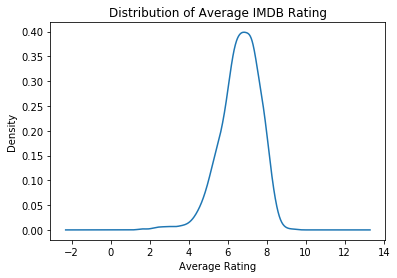

In [0]:
ml['averageRating'].plot(kind = 'kde')
plt.title('Distribution of Average IMDB Rating')
plt.xlabel('Average Rating')

In [0]:
ml['averageRating'].mean(), ml['averageRating'].std()

(6.640127867619398, 1.0106670268561169)

# Train Test Split

In [0]:
text_youtube = pd.read_csv('/content/gdrive/My Drive/feature_extraction/liwc/new_combined.csv', 
                           encoding = "ISO-8859-1",
                           index_col=[0])
ml = pd.merge(ml, text_youtube, left_on= "youtubeId", right_on="audio_fn")

In [0]:
# train test split
y = ml.pop('averageRating')
ml.pop('audio_fn')
X_train, X_test, y_train, y_test = train_test_split(ml, y, test_size=0.20, random_state=42)

In [0]:
train_texts = X_train['text']
test_texts = X_test['text']
text = ml.pop('text')

# Train Random Forest

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_rf_all = X_train.drop(columns = ['youtubeId','title', 'text'])
X_test_rf_all = X_test.drop(columns = ['youtubeId','title', 'text'])
 
tf_vect = TfidfVectorizer(analyzer='word', min_df=2, ngram_range=(1, 3), max_features = 100)
tf_train = tf_vect.fit_transform(train_texts.tolist())
tf_test = tf_vect.transform(test_texts.tolist())
tf_train_df = pd.DataFrame(tf_train.toarray())
X_train_rf_all = pd.concat([X_train_rf_all.reset_index(drop=True), tf_train_df.reset_index(drop=True)], axis = 1)
X_train_rf = X_train_rf_all

tf_test_df = pd.DataFrame(tf_test.toarray())
X_test_rf_all = pd.concat([X_test_rf_all.reset_index(drop=True), tf_test_df.reset_index(drop=True)], axis = 1) 
X_test_rf = X_test_rf_all
X_test_rf.index = X_test.index

In [0]:
# only keep features from recursive feature elimination
rf_feature_df = pd.read_csv('/content/gdrive/My Drive/feature_extraction/rf_feature_select.csv')
features_keep = []
for x in rf_feature_df['selected_feature_name'].tolist():
    if x.isdigit():
        features_keep.append(int(x))
    else:
        features_keep.append(x)
features_keep
X_train_rf = X_train_rf[features_keep]
X_test_rf = X_test_rf[features_keep]

In [0]:
# initial parameter set
# rf_params = {
#     'bootstrap': [True, False],
#     'max_depth': [40, 60, 80, 100, None],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [50, 100, 150]}
rf_params = {
    'bootstrap': [True],
    'max_depth': [10],
    'n_estimators': [100],
    'max_features': ['auto'],
    'min_samples_leaf': [4],
    'min_samples_split': [5]}
rf_clf = GridSearchCV(RandomForestRegressor(), rf_params, cv=3, n_jobs = -1)
grid_result = rf_clf.fit(X_train_rf, y_train)
best_params = grid_result.best_params_
print(best_params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


#Performance Analysis and Feature Importances

Text(0, 0.5, 'Density')

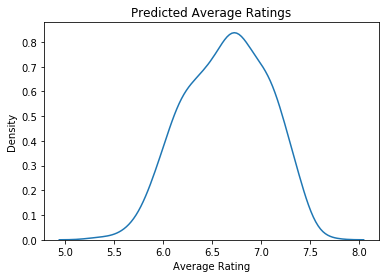

In [0]:
sns.kdeplot(rf_clf.predict(X_test_rf))
plt.title('Predicted Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Density')

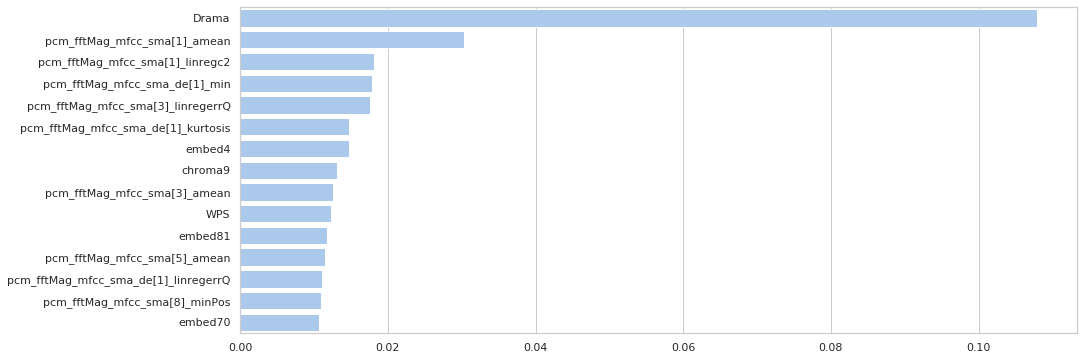

In [0]:
# feature importance plots from random forest model

import seaborn as sns
import matplotlib.pyplot as plt

feat_impts = pd.Series(rf_clf.best_estimator_.feature_importances_,
                       index = X_train_rf.columns).sort_values(ascending = False).head(15)

# plot style
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 6))

# Horizontal bar plot
sns.set_color_codes("pastel")
plot = sns.barplot(x=feat_impts.values, y=feat_impts.index,
            label="Feature Importances", color="b")

In [0]:
# video clips that are not trailers are in the dataset!
# unfortunate, but it lets us understand that embedding 4 encodes
# something related to the intensity of the audio (high embed4 = high intensity)
# and perhaps some element of emotion, too 
X_test.nsmallest(8, ['embed4'])[['youtubeId', 'title']]

,youtubeId,title
900,4yFJVqrln44,Dead Ringers (1988)
1034,KIfH8i9FtCA,Sullivan's Travels (1941)
1452,6q6p3KwyWTk,"Monster Squad, The (1987)"
817,hTKO5taqoAE,Lifeforce (1985)
347,UiGY9JrZQSc,Bonnie and Clyde (1967)
2528,qFuzMlfZGWM,Paddington (2014)
829,LmhsWy7O54E,Rambo: First Blood Part II (1985)
433,gNXQQbgK_cc,Indiana Jones and the Last Crusade (1989)


In [0]:
# overall performance
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
for func in [explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
  print(func.__qualname__, func(y_test, rf_clf.predict(X_test_rf[X_train_rf.columns])))

print('standard deviation absolute error:',np.abs(y_test - rf_clf.predict(X_test_rf[X_train_rf.columns])).std())


explained_variance_score 0.22360454587658196
max_error 4.847585689501659
mean_absolute_error 0.6773518103299253
mean_squared_error 0.8074434007954648
median_absolute_error 0.5294828154262321
r2_score 0.2235374874731505
standard deviation absolute error: 0.5910114165029325


In [0]:
y.std()

1.0106670268561169

In [0]:
# performance by genre
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
          'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
          'Thriller', 'War', 'Western']

genre_perf_dict = {}
for genre in genres:
  mask = X_test_rf[X_test[genre] == 1]
  genre_perf_dict[genre] = {}
  genre_perf_dict[genre]['num_movies'] = mask.shape[0]
  for func in [explained_variance_score, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
    genre_perf_dict[genre][func.__qualname__] = func(y_test.loc[mask.index], rf_clf.predict(mask))

genre_perf_df = pd.DataFrame(genre_perf_dict).T.sort_values(by = 'num_movies', ascending = False)

In [0]:
# genre_perf_df.to_csv('/content/gdrive/My Drive/genre_perf_df.csv')

Text(0.5, 1.0, 'IMDB Average Rating Versus Predicted Rating')

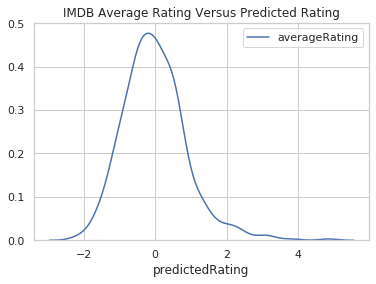

In [0]:
# distribution of errors
sns.kdeplot(rf_clf.predict(X_test_rf[X_train_rf.columns]) - y_test
              # color="g"
              )
plt.xlabel('predictedRating')
plt.title('IMDB Average Rating Versus Predicted Rating')

In [0]:
# distribution of errors by genre
errs_df = np.concatenate([X_test[genres].values,
                          y_test.values.reshape(-1,1),
                          rf_clf.predict(X_test_rf[X_train_rf.columns]).reshape(-1,1)], axis = 1)
errs_df = pd.DataFrame(errs_df, columns = genres + ['averageRating', 'predictedRating'])

In [0]:
errs_by_genre = errs_df.apply(lambda row: np.dot(row[genres].values, np.abs(row['averageRating'] - row['predictedRating'])), axis = 1)
errs_by_genre_df = pd.DataFrame.from_items(zip(errs_by_genre.index, errs_by_genre.values)).T
errs_by_genre_df.columns = genres
errs_by_genre_df = errs_by_genre_df.replace(0, np.nan)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


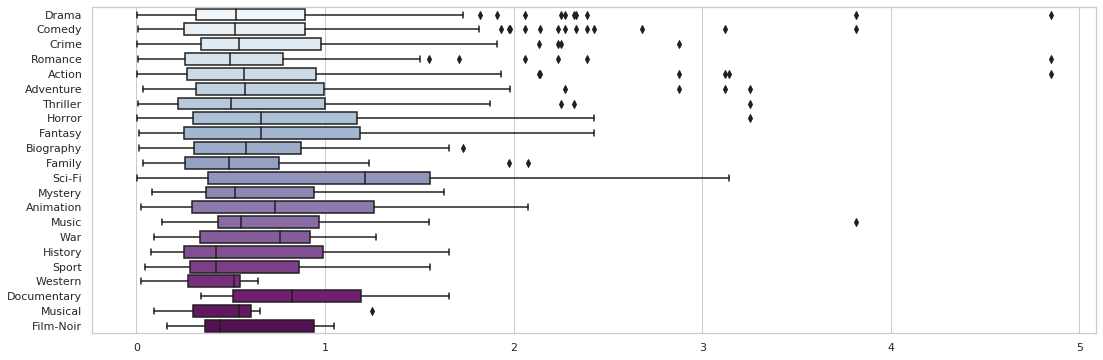

In [0]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
sns.boxplot(data=errs_by_genre_df, ax = ax, orient = 'h', order = genre_perf_df.index, palette = 'BuPu')

# Merge in budget to analyze whether our top features are simply a proxy for production budget (and hence, marketing budget, since the two are correlated).

In [0]:
 # https://www.kaggle.com/rounakbanik/the-movies-dataset

budgets = pd.read_csv('/content/gdrive/My Drive/movies_metadata.csv', usecols = ['imdb_id', 'budget'])
budgets = budgets[budgets['imdb_id'].notnull()]
budgets['imdb_id'] = budgets['imdb_id'].astype(str).apply(lambda x: x[2:])
budgets = budgets[budgets['imdb_id'] != '']
budgets['imdb_id'] = budgets['imdb_id'].astype(int)
budgets['budget'] = budgets['budget'].astype(int)
budgets = budgets[budgets['budget'] > 1000]
budgets = budgets.rename(columns = {'imdb_id': 'imdbId'})
budget_df = pd.merge(pd.merge(budgets, final[['title', 'imdbId']]), ml).drop(['imdbId', 'youtubeId'], axis = 1)

In [0]:
budget_corrs = budget_df.corr()['budget']
budget_corrs = budget_corrs[budget_corrs.notnull()]

In [0]:
corrs = pd.DataFrame(budget_corrs[budget_corrs.abs().sort_values(ascending = False).index[0:20]][1:]).reset_index()
corrs.columns = ['Feature', 'Correlation with Budget']
corrs = corrs.round(2)
corrs.to_csv('/content/gdrive/My Drive/budget_corrs.csv', index = False)

In [0]:
corrs

,Feature,Correlation with Budget
0,Action,0.34
1,Adventure,0.30
2,pcm_fftMag_spectralRollOff50.0_sma_amean,0.25
3,pcm_fftMag_spectralRollOff75.0_sma_amean,0.24
4,pcm_fftMag_spectralRollOff25.0_sma_amean,0.24
5,pcm_fftMag_mfcc_sma[1]_amean,-0.23
6,pcm_fftMag_spectralRollOff90.0_sma_amean,0.22
7,pcm_fftMag_mfcc_sma[1]_min,-0.21
8,pcm_fftMag_mfcc_sma[1]_linregc2,-0.20
9,pcm_zcr_sma_skewness,-0.19


## Importances by Genre

In [0]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(rf_clf.best_estimator_)
shap_values = explainer.shap_values(X_test_rf)

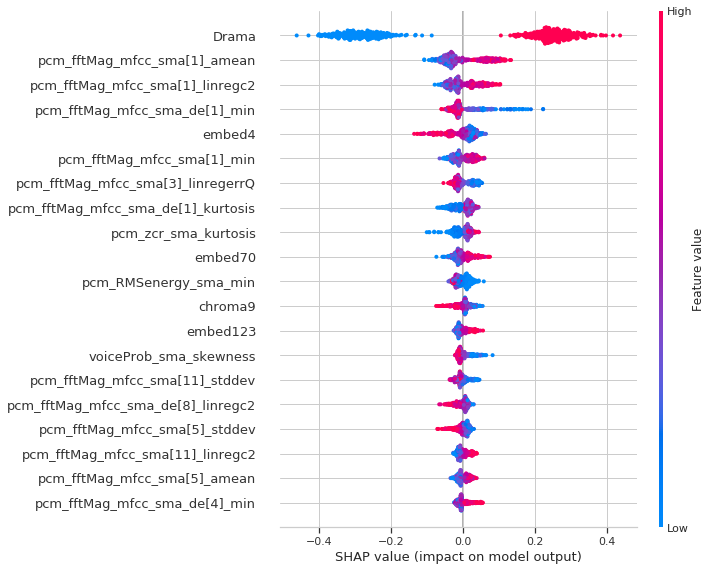

In [0]:
shap.summary_plot(shap_values, X_test_rf)

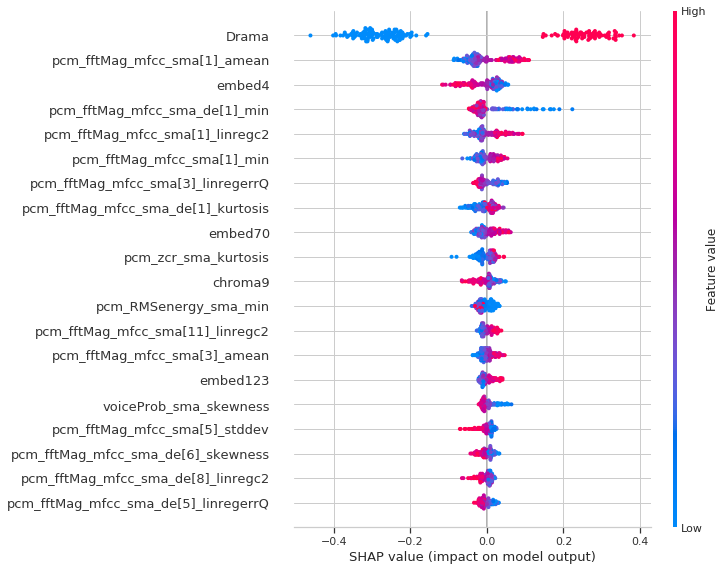

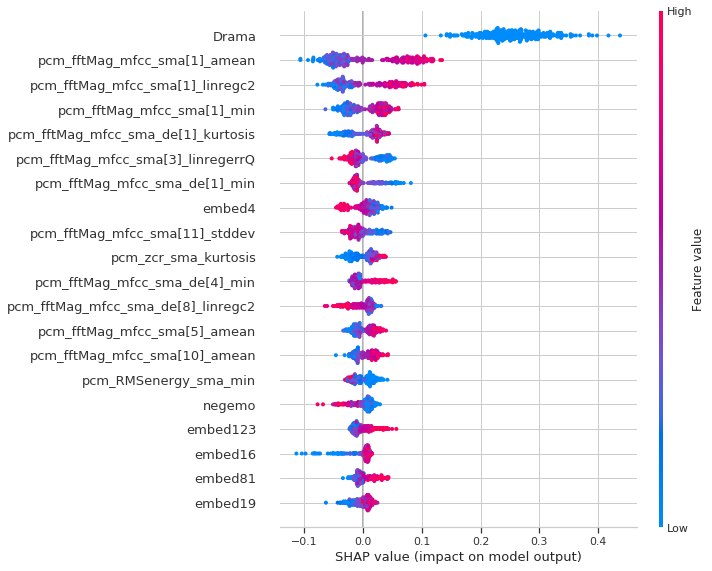

In [0]:
gen_films = X_test_rf[X_test['Comedy'] == 1][X_train_rf.columns]
shap.summary_plot(shap_values[(X_test['Comedy'] == 1).values], gen_films)

gen_films = X_test_rf[X_test['Drama'] == 1][X_train_rf.columns]
shap.summary_plot(shap_values[(X_test['Drama'] == 1).values], gen_films)

## EDA on prosodic feature variance versus quality

In [0]:
genre_perf_df = pd.read_csv('/content/gdrive/My Drive/genre_perf_df.csv', index_col = [0])

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


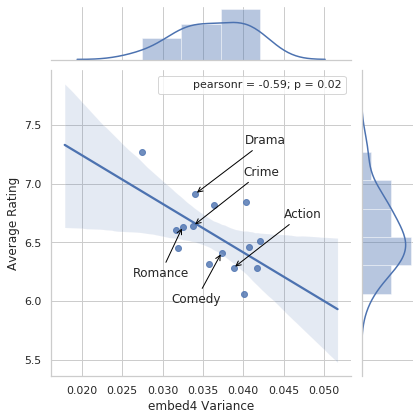

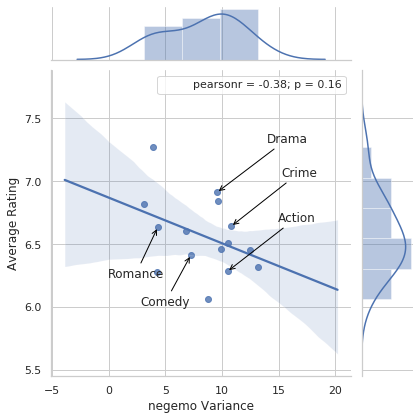

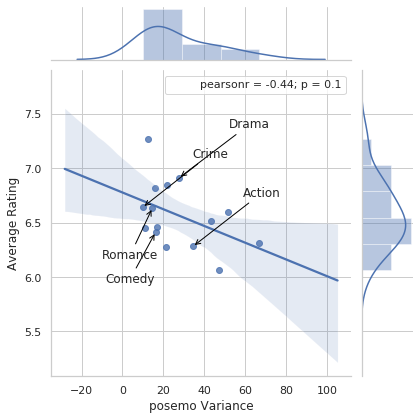

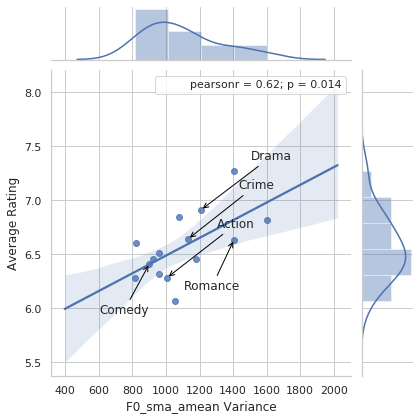

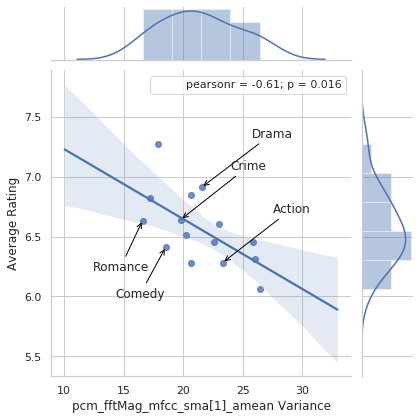

In [0]:
# ml['embed4'].plot(kind = 'kde') # normally distributed, so we can use bartlett's test
# print(bartlett(ml[ml['Drama'] == 1]['embed4'], ml[ml['Drama'] != 1]['embed4']))
# print('Drama var:', ml[ml['Drama']==1]['embed4'].var(), ',', 'Non-drama var:', ml[ml['Drama']!=1]['embed4'].var())

from scipy.stats import bartlett, pearsonr

def ann(row):
    ind = row[0]
    r = row[1]
    flip = (ind % 2 * -1 )
    if flip == 0:
      flip = 1
    plt.gca().annotate(r['Genre'], xy=(r["Variance"], r["Average_Rating"]), 
                       xytext=(flip * 50,flip * 50),
                       textcoords ="offset points", 
                       arrowprops = {'arrowstyle': '->', 'connectionstyle':"arc3", 'color':'black'})

def plotVarianceVersusMeanRating(varname):
  # plot regression of embed4 against mean rating by genre
  xs = [ml[ml[genre] == 1][varname].var() for genre in genres]
  ys = [y[ml[ml[genre]==1].index].mean() for genre in genres]
  lmdf = pd.DataFrame([xs,ys,genres]).T
  lmdf.columns = ['Variance', 'Average_Rating', 'Genre']
  lmdf['Variance'] = lmdf['Variance'].astype('float')
  lmdf['Average_Rating'] = lmdf['Average_Rating'].astype('float')
  lmdf = lmdf.set_index('Genre').loc[genre_perf_df.index].reset_index().rename(columns = {'index': 'Genre'}).head(15)
  reg = sns.jointplot('Variance', 'Average_Rating', lmdf, kind = 'reg')
  reg.annotate(pearsonr)
  reg.set_axis_labels(varname + ' Variance', 'Average Rating')
  for row in lmdf.head().iterrows():
    ann(row)
  
plotVarianceVersusMeanRating('embed4')
plotVarianceVersusMeanRating('negemo')
plotVarianceVersusMeanRating('posemo')
plotVarianceVersusMeanRating('F0_sma_amean')
plotVarianceVersusMeanRating('pcm_fftMag_mfcc_sma[1]_amean')


# Extra code below.

Code for generating features from prosodic embeddings.

```
# generate prosodic embedding features

import numpy as np
# merge in prosody embeddings and collect mean
# get all embeddings
embeddings_files = glob.glob('/content/gdrive/My Drive/prosody_embeddings/*.npy')
embeddings_dict = {}
for yt_link in final['youtubeId']:
  for f in embeddings_files:
    if yt_link in f:
      if yt_link not in embeddings_dict:
        embeddings_dict[yt_link] = []
      embeddings_dict[yt_link].append(np.load(f))

# create 1D numpy arrays by taking mean
for key in embeddings_dict:
  embeddings_dict[key] = np.mean(np.array(embeddings_dict[key]), axis = 0).flatten()

# create dataframe
prosody_df = pd.DataFrame.from_dict(embeddings_dict, orient='index')
prosody_df.columns = 'embed' + prosody_df.columns.astype(str)
prosody_df = prosody_df.rename_axis('youtubeId').reset_index()

prosody_df.to_csv('/content/gdrive/My Drive/mean_prosody_df.csv', index=False)
```

Code for feature selection using Recursive Feature Elimination

```
# train random forest
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import TfidfVectorizer

rf = RandomForestRegressor(n_estimators=100, n_jobs = -1)
selector = RFE(rf, 100, step=1)
X_train_texts = X_train["text"]
X_test_texts = X_test["text"]
rf_feature_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/feature_extraction/rf_feature_lowlevel.csv')

X_train_rf = X_train.drop(columns = ['youtubeId', 'audio_fn','title', 'text'])
X_test_rf = X_test.drop(columns = ['youtubeId', 'audio_fn','title', 'text'])
features_keep = rf_feature_df['selected_feature_name'].tolist()
X_train_rf = X_train_rf[features_keep]
X_test_rf = X_test_rf[features_keep]
print("start")


tf_vect = TfidfVectorizer(analyzer='word', min_df=2, ngram_range=(1, 3), max_features = 100)
tf_train = tf_vect.fit_transform(X_train_texts.tolist())
tf_test = tf_vect.transform(X_test_texts.tolist())
tf_train_df = pd.DataFrame(tf_train.toarray())
X_train_rf = pd.concat([X_train_rf.reset_index(drop=True), tf_train_df.reset_index(drop=True)], axis = 1)
tf_test_df = pd.DataFrame(tf_test.toarray())
X_test_rf = pd.concat([X_test_rf.reset_index(drop=True), tf_test_df.reset_index(drop=True)], axis = 1)

rf = RandomForestRegressor(n_estimators=100, n_jobs = -1)


X_train_col = X_train_rf.columns.tolist()
assert X_test_rf.columns.tolist() == X_train_col
X_train_rf = selector.fit_transform(X_train_rf, y_train)
X_test_rf = selector.transform(X_test_rf)

selected_features, rank = selector.support_, selector.ranking_

from collections import deque
feature_indices = deque(sorted([i for i in range(len(selected_features)) if selected_features[i]]))

rf_feature_df = pd.DataFrame(columns = ['rank', 'feature_category', 'selected_feature_name'])
tfidf_dict = {y:x for x,y in tf_vect.vocabulary_.items()}
for best_feature_idx, r in zip(feature_indices, rank):
    feature_name = X_train_col[best_feature_idx]
    print('feature', feature_name)
    if feature_name in praat_features:
        feature_category = 'praat'
    elif feature_name in liwc_features:
        feature_category = 'liwc'
    elif feature_name in opensmile_features:
        feature_category = 'opensmile'
    elif feature_name in spectral_df:
        feature_category = 'spectral'
    elif feature_name in chroma_df:
        feature_category = 'chroma'
    elif type(feature_name) == str and 'embed' in feature_name:
        feature_category = 'prosodic_embed'
    elif feature_name in tfidf_dict.keys():
        feature_category = 'tf-idf:{}'.format(tfidf_dict[feature_name])
    else:
        feature_category = "genre"
    rf_feature_df= rf_feature_df.append(pd.Series([r, feature_category,feature_name], index=rf_feature_df.columns), ignore_index=True)

rf_feature_df.to_csv('/content/gdrive/My Drive/feature_extraction/rf_feature_select.csv')

```